<a href="https://colab.research.google.com/github/ELGHAZI-85/Horse-to-Zebra-CycleGan-/blob/main/horse_zebra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Horse To Zebra***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### ***Dependecies***

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from torch.cuda.amp.autocast_mode import autocast
import torchvision.utils as vutils
import torch.optim as optim

### ***Data***

> Horse test data

Number of horse photos in test dataset  120


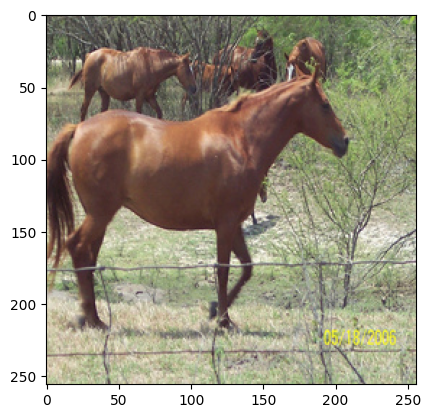

In [5]:
folder_path = "/content/drive/MyDrive/testA"
# Get list of all image files in folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".jpg")]
print("Number of horse photos in test dataset ", len(image_files))
img = Image.open(image_files[86])
plt.imshow(img)
plt.show()
#1067

> Zebra test data

Number of Zebra photos in test dataset  140


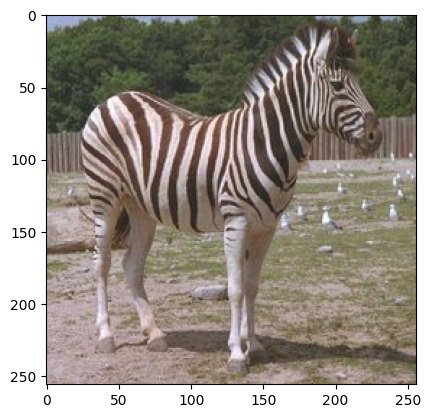

In [6]:
folder_path = "/content/drive/MyDrive/testB"
# Get list of all image files in folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".jpg")]
print("Number of Zebra photos in test dataset ", len(image_files))
img = Image.open(image_files[86])
plt.imshow(img)
plt.show()

#1334

### ***Data Preprocessing***

> Transformations:

      1. Redimensionner l'image 
      2. Effectuer une rotation horizontale aléatoire.
      3. Normaliser les valeurs de pixel.
      4. Convertir l'image en un tenseur PyTorch. 

In [8]:
# albumentations
transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)

> Custom dataset

In [9]:
class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images)) # 1000, 1500
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)
  
    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        zebra_img = np.array(Image.open(zebra_path).convert("RGB"))
        horse_img = np.array(Image.open(horse_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=zebra_img, image0=horse_img)
            zebra_img = augmentations["image"]
            horse_img = augmentations["image0"]

        return zebra_img, horse_img

### **Discriminator**

In [10]:
# 
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                4,
                stride,
                1, # bordure de valeur 1 autour de l'image
                bias=True,
                padding_mode="reflect", # réfléchir les valeurs des bords lors de la mise en œuvre du padding
            ),
            nn.InstanceNorm2d(out_channels), # Normaliser chaque channel indépendamment de l'autre.
            nn.LeakyReLU(0.2), # Conserver un certain nombre de valeurs négatives
        )
    # x tenseur pytorch
    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            # Réduire la taille de l'image en moitié.
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        # 3 layers
        for feature in features[1:]:
            layers.append(
                Block(in_channels, feature, stride=1 if feature == features[-1] else 2)
            )
            in_channels = feature
        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

### **Generator**

In [11]:
# Downsampling ||Upsampling
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity(),
        )

    def forward(self, x):
        return self.conv(x)

# Faciliter l'apprentissage profond en permettent aux gradients de se propager plus facilement à travers les couches profondes
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )
    # residual connection
    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            #nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        # Create a list of pytorch modules
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features, num_features * 2, kernel_size=3, stride=2, padding=1
                ),
                ConvBlock(
                    num_features * 2,
                    num_features * 4,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )
        
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features * 4,
                    num_features * 2,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvBlock(
                    num_features * 2,
                    num_features * 1,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

### **Checkpoints** 

In [ ]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

In [ ]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
# create directory if it does not exist
os.makedirs('saved_models', exist_ok=True)
SAVE_MODEL = True

CHECKPOINT_GEN_H = "/content/drive/MyDrive/gh.pth.tar"
CHECKPOINT_GEN_Z = "/content/drive/MyDrive/gz.pth.tar"
CHECKPOINT_CRITIC_H = "/content/drive/MyDrive/ch.pth.tar"
CHECKPOINT_CRITIC_Z = "/content/drive/MyDrive/cz.pth.tar"

### **Train**

In [ ]:
import os

if not os.path.exists('/content/drive/MyDrive/saved_images'):
    os.makedirs('/content/drive/MyDrive/saved_images')


In [12]:
def train_fn(disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):

    # La performance du discriminateur de cheval
    H_reals = 0
    H_fakes = 0
    # barre de progression qui est mise à jour à chaque lot de loader.
    loop = tqdm(loader, leave=True)

    # idx: indice de l'itération en cours, zebra et horse pytorch tensors
    for idx, (zebra, horse) in enumerate(loop):

       # Envoyer ces données au GPU, s'il existe. 
        zebra = zebra.to("cuda" if torch.cuda.is_available() else "cpu")
        horse = horse.to("cuda" if torch.cuda.is_available() else "cpu")

        # Train Discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_horse = gen_H(zebra)
            D_H_real = disc_H(horse)
            D_H_fake = disc_H(fake_horse.detach())

            # La performance du descriminateur du chevaux.
            H_reals += D_H_real.mean().item()
            H_fakes += D_H_fake.mean().item()

            # perte de la différence entre la sortie réelle et la valeur de vérité (torch.ones_like(D_H_real))
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss

            fake_zebra = gen_Z(horse)
            D_Z_real = disc_Z(zebra)
            D_Z_fake = disc_Z(fake_zebra.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss

            # put it togethor
            D_loss = (D_H_loss + D_Z_loss) / 2


        # Mise à jour des poids 
        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()


        # Train Generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            D_H_fake = disc_H(fake_horse)
            D_Z_fake = disc_Z(fake_zebra)
            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            # cycle loss

            cycle_zebra = gen_Z(fake_horse)
            cycle_horse = gen_H(fake_zebra)
            
            # Distances entre image original et image reconstruit  
            cycle_zebra_loss = l1(zebra, cycle_zebra)
            cycle_horse_loss = l1(horse, cycle_horse)

            identity_zebra = gen_Z(zebra)
            identity_horse = gen_H(horse)
            identity_zebra_loss = l1(zebra, identity_zebra)
            identity_horse_loss = l1(horse, identity_horse)

            # le générateur n'est pas encouragé à produire une copie identique de l'image d'entrée
            LAMBDA_IDENTITY = 0.0
            # Pénalité sur la différence entre l'image d'entrée et la même image reconstruit
            LAMBDA_CYCLE = 10

            # add all togethor
            G_loss = (
                loss_G_Z
                + loss_G_H
                + cycle_zebra_loss * LAMBDA_CYCLE
                
                + cycle_horse_loss * LAMBDA_CYCLE
                + identity_horse_loss * LAMBDA_IDENTITY
                + identity_zebra_loss * LAMBDA_IDENTITY
            )
        # Mise à jour des poids
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            vutils.save_image(fake_horse * 0.5 + 0.5 , f"/content/drive/MyDrive/saved_images/horse_{idx}.png")
            vutils.save_image(fake_zebra * 0.5 + 0.5 , f"/content/drive/MyDrive/saved_images/zebra_{idx}.png")

        loop.set_postfix(H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1))

In [ ]:
# Fonction principale

def main():
    # Créer deux générateurs et deux descriminateurs
    disc_H = Discriminator(in_channels=3).to("cuda" if torch.cuda.is_available() else "cpu")
    disc_Z = Discriminator(in_channels=3).to("cuda" if torch.cuda.is_available() else "cpu")
    gen_Z = Generator(img_channels=3, num_residuals=9).to("cuda" if torch.cuda.is_available() else "cpu")
    gen_H = Generator(img_channels=3, num_residuals=9).to("cuda" if torch.cuda.is_available() else "cpu")

    # Optimisateur pour le dicriminateur
    opt_disc = optim.Adam(
        list(disc_H.parameters()) + list(disc_Z.parameters()),
        lr= 2e-4,
        betas=(0.5, 0.999),
    )

    # Optimisateur pour le générateur
    opt_gen = optim.Adam(
        list(gen_Z.parameters()) + list(gen_H.parameters()),
        lr=2e-4,
        betas=(0.5, 0.999),
    )

    # Mean Absolute Erro
    L1 = nn.L1Loss()

    # Mean Squared Error
    mse = nn.MSELoss()
    """
    if True:
        
        load_checkpoint(
            CHECKPOINT_GEN_H,
            gen_H,
            opt_gen,
            2e-4,
        )
        load_checkpoint(
            CHECKPOINT_GEN_Z,
            gen_Z,
            opt_gen,
            2e-4,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_H,
            disc_H,
            opt_disc,
            2e-4,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_Z,
            disc_Z,
            opt_disc,
            2e-4,
      )
    """

    # train dataset
    dataset = HorseZebraDataset(
        root_horse = '/content/drive/MyDrive/trainA',
        root_zebra = '/content/drive/MyDrive/trainB',
        transform=transforms,
    )

    # validation dataset
    val_dataset = HorseZebraDataset(
        root_horse="/content/drive/MyDrive/testA",
        root_zebra="/content/drive/MyDrive/testB",
        transform=transforms,
    )
     
    # Validation_loader
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
    )

    # train_loader
    loader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=True,
        num_workers=4, # Accélérer le chargement des données
        pin_memory=True, # Epingler les données dans la mémoire
    )

    # réaliser de manière efficace le calcul en demi-précision
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(200):
        train_fn(
            disc_H,
            disc_Z,
            gen_Z,
            gen_H,
            loader,
            opt_disc,
            opt_gen,
            L1,
            mse,
            d_scaler,
            g_scaler,
        )

        if SAVE_MODEL:
            save_checkpoint(gen_H, opt_gen, filename = CHECKPOINT_GEN_H)
            save_checkpoint(gen_Z, opt_gen, filename = CHECKPOINT_GEN_Z)
            save_checkpoint(disc_H, opt_disc, filename = CHECKPOINT_CRITIC_H)
            save_checkpoint(disc_Z, opt_disc, filename = CHECKPOINT_CRITIC_Z)

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1334/1334 [05:32<00:00,  4.01it/s, H_fake=0.375, H_real=0.607]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:33<00:00,  4.00it/s, H_fake=0.313, H_real=0.642]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:32<00:00,  4.02it/s, H_fake=0.359, H_real=0.608]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:32<00:00,  4.02it/s, H_fake=0.385, H_real=0.58]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:31<00:00,  4.03it/s, H_fake=0.388, H_real=0.584]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:31<00:00,  4.03it/s, H_fake=0.396, H_real=0.578]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:31<00:00,  4.03it/s, H_fake=0.398, H_real=0.576]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:30<00:00,  4.04it/s, H_fake=0.394, H_real=0.581]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:32<00:00,  4.02it/s, H_fake=0.395, H_real=0.577]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:33<00:00,  4.00it/s, H_fake=0.402, H_real=0.577]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:31<00:00,  4.02it/s, H_fake=0.4, H_real=0.58]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:32<00:00,  4.02it/s, H_fake=0.397, H_real=0.58]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:30<00:00,  4.04it/s, H_fake=0.396, H_real=0.582]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:30<00:00,  4.04it/s, H_fake=0.396, H_real=0.582]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:31<00:00,  4.03it/s, H_fake=0.394, H_real=0.583]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:30<00:00,  4.03it/s, H_fake=0.392, H_real=0.583]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:33<00:00,  4.00it/s, H_fake=0.395, H_real=0.585]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:32<00:00,  4.01it/s, H_fake=0.393, H_real=0.581]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:30<00:00,  4.04it/s, H_fake=0.391, H_real=0.584]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:31<00:00,  4.02it/s, H_fake=0.397, H_real=0.584]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [05:29<00:00,  4.05it/s, H_fake=0.399, H_real=0.58]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


 58%|█████▊    | 771/1334 [03:10<02:17,  4.08it/s, H_fake=0.397, H_real=0.586]